#Preprocessing

### Mount Google Drive

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Install Required Libraries

In [43]:
!pip install PyMuPDF nltk emoji beautifulsoup4

 ### Read Native PDF from Google Drive

In [44]:
import fitz  # PyMuPDF

pdf_path = "/content/drive/MyDrive/mid-term/Question1.pdf"

def extract_text_from_pdf(path):
    doc = fitz.open(path)
    full_text = ""
    for page in doc:
        full_text += page.get_text()
    return full_text

raw_text = extract_text_from_pdf(pdf_path)
print(raw_text[:10000])  # preview

Mushrooms: Types and Edibility 
Post 1: 
Heyyy!! Sooo, like... have u ever walked thru a forest 🍄 and thought, "Whoa! Is 
*that* mushroom edible or nah???" 🤔🤷♀️ Honestly, mushrooms are *super* cool 
(and kinda sus at the same time lol). Anyway, let’s talk shrooms! 😅😂 
 
Mushrooms (or should I say mushies 🍄🍄) come in sooooo many diff types — it's 
insane. You got your classic white button (aka Agaricus bisporus, I know... fancy 
stuff 🤓), then there’s shiitake (not shit take lol), oyster, lion’s mane (looks like a 
fluffy cloud ngl ☁️), and ofc, the wild bois like chanterelles and morels 🧡. Oh, and 
don’t forget porcini, enoki, and those lil black truffle bad boys $$$ 🤑 
 
But like, hold up ✋ — not all mushrooms are friendly. Some are DEADLY (like... 
literally 💀). Amanita phalloides (aka fuckn death cap ☠️) looks hella normal, but 
will end ya. No cap. 😬 Some others like the Destroying Angel, false morels, and fly 
agaric are tryna play games with ur life. Just coz it cute doesn’t mean

In [45]:
!pip install better_profanity

In [46]:
!pip install pyspellchecker

### Pre Processing Function

In [47]:
import re
import emoji
from bs4 import BeautifulSoup
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from better_profanity import profanity
from spellchecker import SpellChecker
import nltk

# Download NLTK resources
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Setup
spell = SpellChecker()
profanity.load_censor_words()
custom_bad_words = ['fuckn', 'fck', 'fuk', 'fckn', 'fkn', 'sh1t', 'b1tch']
profanity.add_censor_words(custom_bad_words)

def preprocess_sentence(sentence):
    # Clean HTML
    sentence = BeautifulSoup(sentence, "html.parser").get_text()

    # Lowercase
    sentence = sentence.lower()

    # Emoji to text
    sentence = emoji.demojize(sentence)
    sentence = re.sub(r'(:[a-zA-Z0-9_]+:)(?=:[a-zA-Z0-9_]+:)', r'\1 ', sentence)
    sentence = re.sub(r':([a-zA-Z0-9_]+):', lambda m: m.group(1).replace('_', ' '), sentence)

    # Expand contractions
    contractions = {
        "isn't": "is not", "can't": "cannot", "i'm": "i am",
        "it's": "it is", "they're": "they are", "don't": "do not"
    }
    for k, v in contractions.items():
        sentence = sentence.replace(k, v)

    # Remove punctuation (keep hashtags/mentions)
    sentence = re.sub(r'[^\w\s#@]', '', sentence)

    # Normalize whitespace
    sentence = re.sub(r'\s+', ' ', sentence).strip()

    # Tokenize words
    tokens = word_tokenize(sentence)

    # Spell correction
    corrected_tokens = [spell.correction(w) if w.isalpha() else w for w in tokens]

    # Remove stopwords & profanity
    stop_words = set(stopwords.words('english'))
    cleaned_tokens = [w for w in corrected_tokens if w not in stop_words and not profanity.contains_profanity(w)]

    # Stemming & Lemmatization
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(w) for w in cleaned_tokens]

    return ' '.join(lemmas)  # clean sentence text


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [48]:
# Split raw text into sentences
from nltk.tokenize import sent_tokenize

sentences = sent_tokenize(raw_text)  # raw_text from PDF extraction
preprocessed_sentences = [preprocess_sentence(sent) for sent in sentences if len(sent.strip()) > 2]

print("Example preprocessed sentence:", preprocessed_sentences[0])


Example preprocessed sentence: mushroom type edibility post 1 heavy


### Vectorize the Sentences (Encoding using tf idf and bag of words)

In [49]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Bag of Words
X_bow = CountVectorizer().fit_transform(preprocessed_sentences)

# TF-IDF
X_tfidf = TfidfVectorizer().fit_transform(preprocessed_sentences)


### Assigning labels

In [50]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [51]:
sentiment_labels = []

for sentence in preprocessed_sentences:
    score = sia.polarity_scores(sentence)['compound']
    if score >= 0.05:
        sentiment_labels.append('positive')
    elif score <= -0.05:
        sentiment_labels.append('negative')
    else:
        sentiment_labels.append('neutral')

Text PreProcessing Questions:

1. Which text pre-processing steps did you apply to your extracted PDF text, and in what order?

  I first split the raw extracted PDF text into sentences using NLTK’s sent_tokenize. Then for each sentence, I applied multiple preprocessing steps in this order:

  - Removed HTML tags with BeautifulSoup

  - Converted all text to lowercase

  - Converted emojis into descriptive text using emoji.demojize

  - Inserted spaces between adjacent emojis and cleaned their format

  - Expanded common contractions manually (like "can't" to "cannot")

  - Removed punctuation except for hashtags and mentions

  - Normalized whitespace

  - Tokenized each sentence into words

  - Applied spelling correction on alphabetic tokens

  - Removed stopwords and profane words

  - Performed lemmatization on the cleaned tokens

  Finally, I joined the cleaned tokens back into a processed sentence.

2. How did you handle special elements like emojis, hashtags, mentions, HTML tags, and contractions in your text?

  I removed HTML tags completely with BeautifulSoup. For emojis, I converted them to text descriptions (e.g., ":smile:") and cleaned those to readable words ("smile"). Hashtags and mentions were preserved by not removing "#" and "@" characters during punctuation removal. For contractions, I manually expanded a small set of common contractions (like "isn't" to "is not") to their full forms to improve clarity and token consistency

3. What techniques and libraries did you use for tokenization, Stemming and lemmatization and how did they perform on informal language?

  I used NLTK’s sent_tokenize for sentence tokenization and word_tokenize for word-level tokenization. For stemming, I used NLTK’s PorterStemmer, and for lemmatization, I used WordNetLemmatizer. The lemmatizer helped normalize words to their base forms, which was particularly useful given the informal language and spelling variations. Stemming was applied but lemmatization was more accurate in retaining meaningful base words in informal contexts.

4. How did you deal with stop words? Did you use a predefined list or customize your own?

  I used NLTK’s predefined English stop words list and removed those stopwords after tokenization and spelling correction. I did not customize the stopword list, but I removed any profane words separately using the better_profanity library with some added custom bad words.

5. How did you detect and remove duplicate words or lines in the text?

  In this pipeline, I did not explicitly remove duplicate sentences or duplicate words across sentences. Each sentence was preprocessed independently and retained as a separate data point for further vectorization and analysis.

6. What challenges did you face in cleaning toxic or profane language, and how did you address them?

  Profane words often have variations and deliberate misspellings, so I used the better_profanity Python package as a base, then added a custom list of common profane variants specific to my data (like "fckn", "sh1t"). This approach helped catch profanities with informal spellings and ensured those tokens were removed during cleaning.

7. Did you use any encoding techniques? What and why? How did you handle misspelling in your data?

  Yes, for encoding text into features, I used vectorization techniques such as Bag-of-Words (CountVectorizer) and TF-IDF (TfidfVectorizer). For misspellings, I applied spelling correction before stopword removal and vectorization, using the spellchecker library to correct alphabetic tokens. This helped reduce noise caused by typos and misspellings.

8. How did you handle out-of-vocabulary (OOV) words during transformation?

  Because I used classical vectorizers like Bag-of-Words and TF-IDF, any OOV words simply do not appear in the fixed vocabulary after fitting on the training data. Additionally, my spelling correction step aimed to reduce OOV occurrences by correcting misspelled words to known dictionary forms.

9. Did you keep or remove numerical values in your text? Justify your choice.

  I retained numerical values during cleaning since I did not specifically remove digits. Numbers might carry meaning depending on the domain or sentiment (e.g., ratings, counts). Since my punctuation removal regex excluded digits, numbers remain in tokens and can contribute to analysis if relevant. No special numeric normalization was applied beyond this.

#EDA

### Token Analysis

Getting count of tokens

In [52]:
from nltk.tokenize import word_tokenize

all_tokens = []

# Tokenize each cleaned sentence into words
for sentence in preprocessed_sentences:
    tokens = word_tokenize(sentence)
    all_tokens.extend(tokens)

total_tokens = len(all_tokens)
unique_tokens = len(set(all_tokens))

print("Total Tokens:", total_tokens)
print("Unique Tokens:", unique_tokens)

Total Tokens: 585
Unique Tokens: 347


Visualize top tokens


Top 15 Tokens:
mushroom: 30
like: 22
face: 19
u: 10
#: 9
edible: 7
tear: 7
joy: 7
look: 7
one: 6
lot: 5
lie: 5
skull: 5
safe: 5
ever: 4


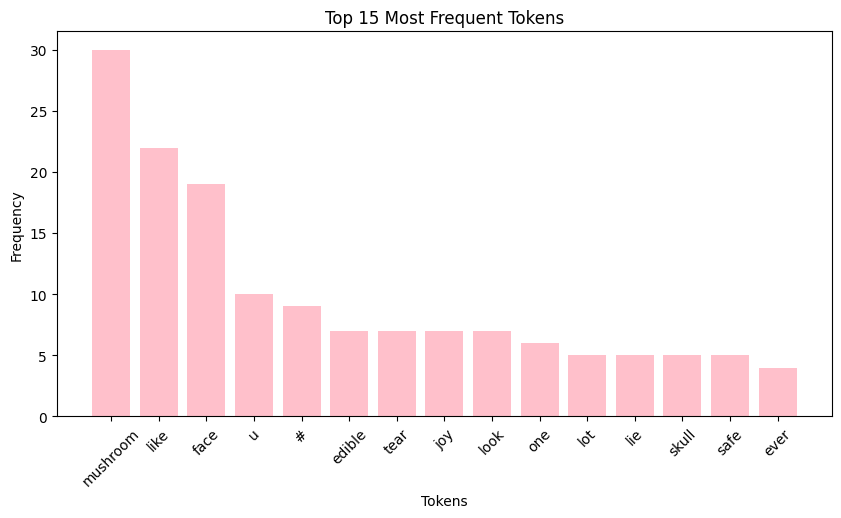

In [53]:
from collections import Counter
import matplotlib.pyplot as plt

token_freq = Counter(all_tokens)
top_tokens = token_freq.most_common(15)

# Print top tokens
print("\nTop 15 Tokens:")
for token, count in top_tokens:
    print(f"{token}: {count}")

# Bar chart
tokens, counts = zip(*top_tokens)
plt.figure(figsize=(10, 5))
plt.bar(tokens, counts, color='pink')
plt.title("Top 15 Most Frequent Tokens")
plt.xlabel("Tokens")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()


### Inspecting remaining noise

In [54]:
import re
from nltk.tokenize import word_tokenize
from collections import defaultdict

def check_remaining_noise(sentences):
    # Initialize issue tracker
    issues = defaultdict(list)

    for sentence in sentences:
        tokens = word_tokenize(sentence)

        for token in tokens:
            if re.match(r'^[a-zA-Z]{1,2}$', token):
                issues["short_fragments"].append(token)
            if re.search(r'(.)\1{2,}', token):  # repeated letters (e.g., sooo)
                issues["elongated_words"].append(token)
            if token == '#':
                issues["standalone_hashtags"].append(token)
            if token == '@':
                issues["standalone_mentions"].append(token)
            if re.match(r'(https?://\S+|www\.\S+)', token):
                issues["urls"].append(token)
            if not token.isalpha():
                issues["non_alpha_tokens"].append(token)

    return issues

# Run the noise check on the new preprocessed sentence list
noise_issues = check_remaining_noise(preprocessed_sentences)

# Print summary of findings
print(" Noise/Anomaly Summary:")
for issue, tokens in noise_issues.items():
    print(f"{issue}: {len(tokens)} instances")
    if tokens:
        print(f"   Examples: {tokens[:10]}")


 Noise/Anomaly Summary:
non_alpha_tokens: 24 instances
   Examples: ['1', 'moneymouth_face', '#', '1', "n't", "n't", '#', '5050', '#', '1']
short_fragments: 27 instances
   Examples: ['u', 'u', 'oh', 'ya', 'ur', 'ur', 'ai', 'u', 'em', 'u']
standalone_hashtags: 9 instances
   Examples: ['#', '#', '#', '#', '#', '#', '#', '#', '#']
standalone_mentions: 1 instances
   Examples: ['@']


Q: Did you identify any remaining noise or anomalies in the text after preprocessing? Describe them.

Yes, even after preprocessing, some noise and anomalies remain in the text. The most notable issues include:

Non-alphabetic tokens (24 instances), such as numbers ('1', '5050'), emojis converted to text ('moneymouth_face'), and contractions like "n't". These elements can affect model performance if not handled properly.

Short fragments (27 instances), including informal shorthand like 'u', 'ur', 'oh', and 'ya'. These are often informal or non-standard words that may not carry meaningful sentiment on their own.

Standalone hashtags (9 instances) and a standalone mention (1 instance) were found. These likely came from partially removed or malformed social media tags (e.g., just '#' or '@' with no content attached), and they don't contribute useful information.

### POS Distribution

Top POS tags:

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets_json to /root/nltk_data...
[nltk_data]   Package tagsets_json is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!



NN: 259
JJ: 113
RB: 48
VBP: 35
IN: 28
VBG: 18
VBD: 16
NNS: 14
CD: 13
VB: 11

Descriptions of top tags:
NN: noun, common, singular or mass
    common-carrier cabbage knuckle-duster Casino afghan shed thermostat
    investment slide humour falloff slick wind hyena override subhumanity
    machinist ...
JJ: adjective or numeral, ordinal
    third ill-mannered pre-war regrettable oiled calamitous first separable
    ectoplasmic battery-powered participatory fourth still-to-be-named
    multilingual multi-disciplinary ...
RB: adverb
    occasionally unabatingly maddeningly adventurously professedly
    stirringly prominently technologically magisterially predominately
    swiftly fiscally pitilessly ...
VBP: verb, present tense, not 3rd person singular
    predominate wrap resort sue twist spill cure lengthen brush terminate
    appear tend stray glisten obtain comprise detest tease attract
    emphasize mold postpone sever return wag ...
IN: preposition or conjunction, subordinating
    a

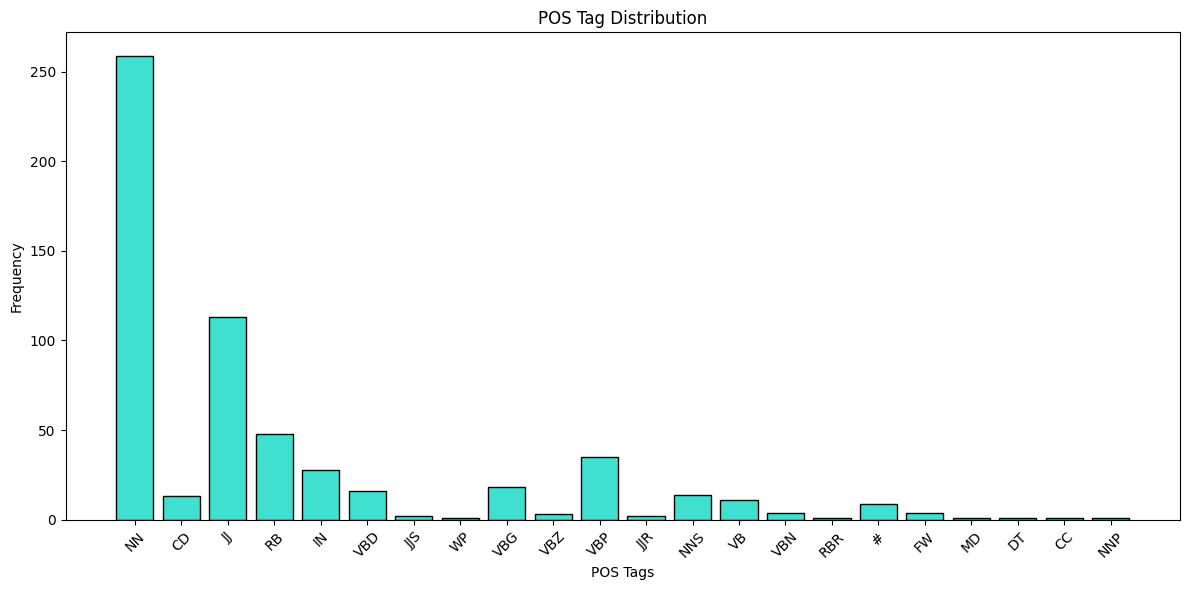

In [55]:
import nltk
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('tagsets_json')
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from collections import Counter
import matplotlib.pyplot as plt


# Download resources
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')

# Flatten all tokens across preprocessed sentences
all_tokens = []
for sentence in preprocessed_sentences:
    all_tokens.extend(word_tokenize(sentence))

# Apply POS tagging
pos_tags = pos_tag(all_tokens)

# Count POS tags
pos_counts = Counter(tag for word, tag in pos_tags)

# Display top 10 POS tags
print("Top POS tags:")
for tag, count in pos_counts.most_common(10):
    print(f"{tag}: {count}")

# Show meanings
print("\nDescriptions of top tags:")
for tag, _ in pos_counts.most_common(10):
    nltk.help.upenn_tagset(tag)

# Plot the POS tag distribution
plt.figure(figsize=(12,6))
plt.bar(pos_counts.keys(), pos_counts.values(), color='turquoise', edgecolor='black')
plt.title("POS Tag Distribution")
plt.xlabel("POS Tags")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Q: Analyze the part-of-speech (POS) distribution in the text. Which categories are most dominant?

Based on the POS distribution results, the most dominant parts of speech in the text are:

Nouns (NN, NNS): Singular common nouns (NN) are the most frequent, with 259 occurrences, and plural nouns (NNS) also appear prominently. This suggests the text is information-rich, likely describing objects, concepts, or topics in detail—consistent with educational or narrative content (e.g., about mushrooms, forests, etc.).

Adjectives (JJ): With 113 instances, adjectives are used frequently to describe or qualify nouns, indicating a descriptive writing style. This supports the idea that the text includes opinions, qualities, or features—likely important in subjective or narrative writing.

Verbs (VBP, VBG, VBD, VB): Verbs are spread across various forms, including present tense (VBP), present participles/gerunds (VBG), past tense (VBD), and base form (VB). This diversity in verb forms suggests a mix of present and past narration, typical of reflective or experiential writing.

Adverbs (RB): With 48 occurrences, adverbs play a noticeable role, modifying verbs and adjectives—reinforcing the conversational and expressive tone of the content.

### Analyze Grammar Structures & Tenses

In [56]:
import nltk
import re
from nltk import pos_tag, word_tokenize
from collections import defaultdict, Counter
from IPython.display import display, HTML

# Download NLTK resources
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Map POS tags to general verb tenses
tense_map = {
    'VBD': 'Past Tense',
    'VBP': 'Present Tense',
    'VBZ': 'Present Tense (3rd Person)',
    'VB': 'Base Form (Infinitive)',
    'VBG': 'Present Participle / Gerund',
    'VBN': 'Past Participle'
}

# Initialize trackers
tense_counts = Counter()
tense_examples = defaultdict(list)
tense_verbs = defaultdict(list)

# Use preprocessed_sentences from the new pipeline
for sent in preprocessed_sentences:
    tokens = word_tokenize(sent)
    pos_tags = pos_tag(tokens)
    tense_to_words = defaultdict(list)

    for word, tag in pos_tags:
        if tag in tense_map:
            tense = tense_map[tag]
            tense_counts[tense] += 1
            tense_to_words[tense].append(word)

    for tense, verbs in tense_to_words.items():
        if len(tense_examples[tense]) < 3:
            highlighted = sent
            for verb in set(verbs):
                highlighted = re.sub(
                    rf'\b{re.escape(verb)}\b',
                    f"<span style='color:blue;font-weight:bold'>{verb}</span>",
                    highlighted,
                    flags=re.IGNORECASE
                )
            tense_examples[tense].append(highlighted)
            tense_verbs[tense].append(list(set(verbs)))

# Display results
display(HTML("<h3>Verb Tense Distribution with Highlighted Verbs</h3>"))
for tense, count in tense_counts.items():
    display(HTML(f"<b>{tense}</b>: {count} verbs"))
    for i, example in enumerate(tense_examples[tense]):
        display(HTML(f"➤ <i>Verbs:</i> {', '.join(tense_verbs[tense][i])}"))
        display(HTML(f"<div style='margin-bottom:10px'>{example}</div>"))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Q: Did you observe any patterns related to grammar structures or tenses in your dataset? Describe with examples.

The grammar and tense analysis shows that present tense verbs dominate the text, especially in conversational forms like "say," "come," "look," and "know". This suggests a casual, present-focused narrative style.

Present participles (e.g., "thinking," "shrugging") are also common, showing an expressive or reflective tone. Past tense verbs like "walked" and "got" indicate a storytelling or personal experience nature to the narrative.

Less common are base form and past participle verbs, used in descriptive or imperative phrases.

Overall, the mix of tenses indicate an informal, expressive tone, which is akin to a personal or social media-style content.

### Word Cloud and Bar Chart

In [57]:
!pip install wordcloud matplotlib

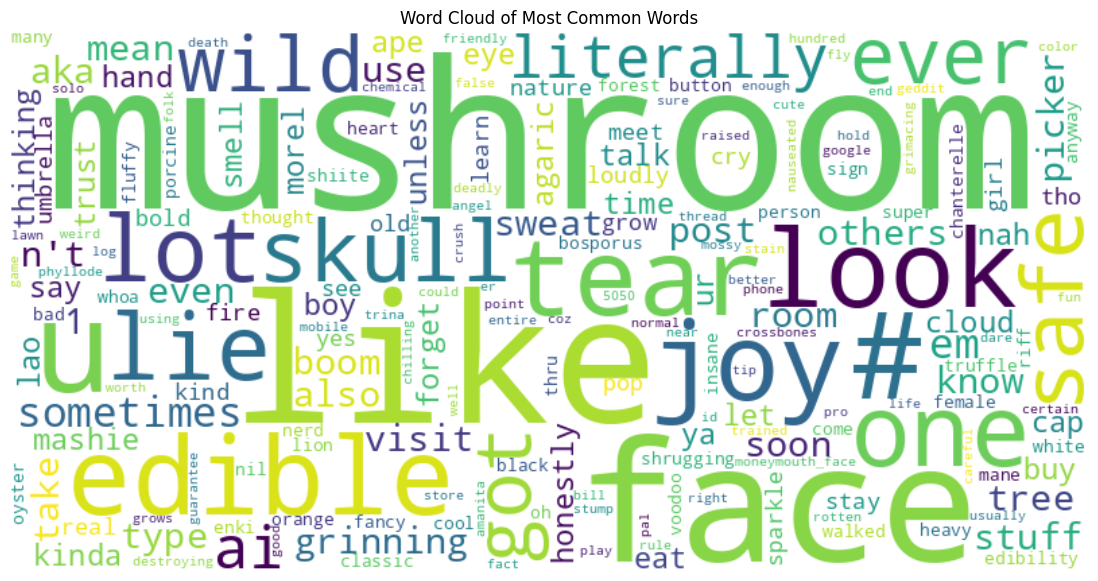

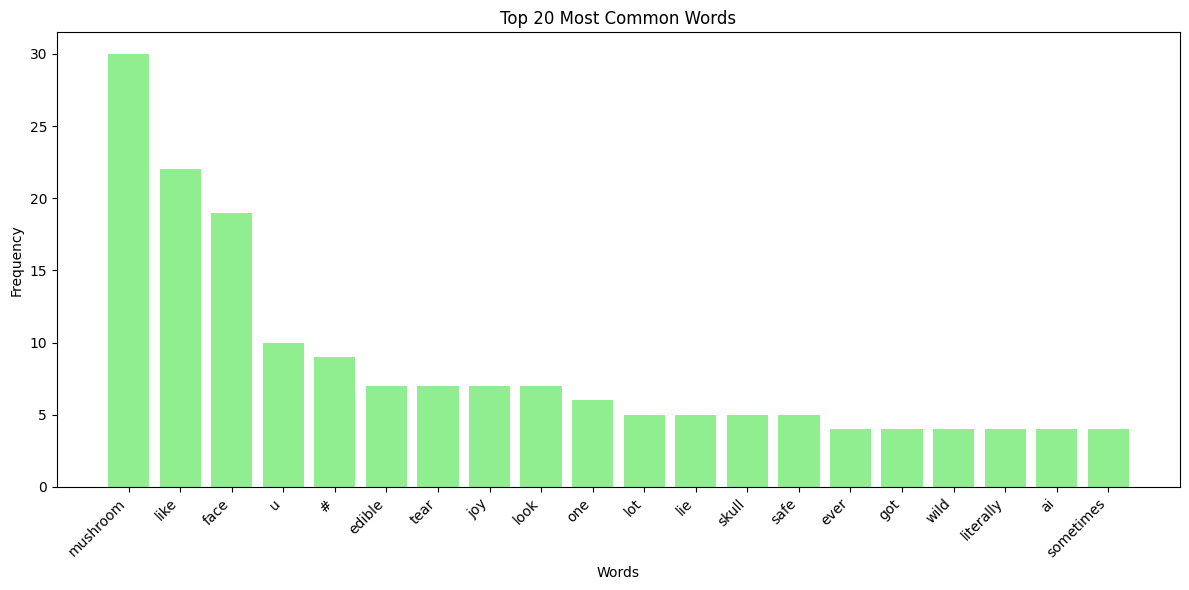

In [58]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from nltk.tokenize import word_tokenize

# Flatten tokens from all preprocessed sentences
all_tokens = []
for sentence in preprocessed_sentences:
    tokens = word_tokenize(sentence)
    all_tokens.extend(tokens)

# Count word frequencies
word_freq = Counter(all_tokens)

# --- Word Cloud ---
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Most Common Words")
plt.show()

# --- Bar Chart for Top 20 Words ---
most_common_words = word_freq.most_common(20)
words, counts = zip(*most_common_words)

plt.figure(figsize=(12, 6))
plt.bar(words, counts, color='lightgreen')
plt.xticks(rotation=45, ha='right')
plt.title("Top 20 Most Common Words")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


Q: What insights can you draw from the most
common words?

Based on the bar chart and word cloud, the text primarily focuses on mushrooms—covering topics like types, edibility, and forest settings—suggesting an educational or informational nature. The frequent use of informal words like heyyy, sooo, and kinda indicates a casual, conversational tone, likely from social media or personal posts. Words like walked, thought, and face point to narrative or reflective content. The presence of post and the number 1 suggest online discussion and possible enumeration. Overall, it blends informal language with mushroom-focused content, giving it a relatable and approachable feel.

### Insights from EDA

What insights about writing style, tone, or topic can you infer from your EDA
findings?

The EDA shows that the text is centered around mushrooms, with frequent mentions of terms like edibility, types, forest, and post. This suggests the content is likely educational or experience-based, possibly from forums or user-generated sources discussing mushroom foraging.

The tone is clearly informal and conversational, shown by the frequent use of slang and casual expressions like heyyy, sooo, and kinda. The presence of interjections and repeated letters reflects a friendly, personal writing style—typical of social media or blog posts.

Grammatical and POS analysis supports this with a high usage of personal pronouns and past-tense verbs, pointing to narrative or reflective storytelling. The mix of past and present tense shows the writer is recounting past experiences while also explaining things in the moment.

Additionally, the balanced use of nouns and verbs, along with descriptive adjectives, suggests a mix of action and observation. The text uses accessible vocabulary and shows moderate lexical variety, reinforcing that it’s written in a casual, approachable way for a general audience.

# Classification

Installing transformers

In [59]:
!pip install transformers

Generate BERT embeddings

In [60]:
from transformers import BertTokenizer, BertModel
import torch
import numpy as np

# Load pretrained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
model.eval()  # Set to eval mode (no dropout)

def bert_encode(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512, padding='max_length')
    with torch.no_grad():
        outputs = model(**inputs)
    # CLS token embedding represents the sentence
    cls_embedding = outputs.last_hidden_state[:, 0, :]
    return cls_embedding.squeeze().numpy()

# Generate embeddings for all texts
X_bert = np.array([bert_encode(doc) for doc in preprocessed_sentences])


### Classification Model Code

In [61]:
# === Imports and downloads ===
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, roc_auc_score
import time
import numpy as np

# === Step 1: ===
# Vectorization (already done):
X = X_tfidf

# === Step 2: Assign sentiment labels using VADER ===
sia = SentimentIntensityAnalyzer()

def get_sentiment_label(text):
    scores = sia.polarity_scores(text)
    compound = scores['compound']
    if compound >= 0.05:
        return "positive"
    elif compound <= -0.05:
        return "negative"
    else:
        return "neutral"

labels = [get_sentiment_label(text) for text in preprocessed_sentences]

# Check class distribution
from collections import Counter
print("Sentiment distribution:", Counter(labels))


Sentiment distribution: Counter({'positive': 35, 'neutral': 27, 'negative': 14})


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Split dataset

In [62]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_bert, labels, test_size=0.2, random_state=42, stratify=labels)

Define your classifiers

In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Gaussian Naive Bayes": GaussianNB(),
    "Linear SVM": LinearSVC(max_iter=10000),
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
}


Train, predict, and evaluate all classifiers

In [64]:
from sklearn.metrics import accuracy_score, classification_report
import time

for name, clf in classifiers.items():
    start_train = time.time()
    clf.fit(X_train, y_train)
    end_train = time.time()

    start_pred = time.time()
    y_pred = clf.predict(X_test)
    end_pred = time.time()

    print(f"\nClassifier: {name}")
    print(f"Training time: {end_train - start_train:.3f} sec")
    print(f"Prediction time: {end_pred - start_pred:.3f} sec")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
    print(classification_report(y_test, y_pred, digits=4))



Classifier: Logistic Regression
Training time: 0.059 sec
Prediction time: 0.000 sec
Accuracy: 0.625
              precision    recall  f1-score   support

    negative     0.3333    0.3333    0.3333         3
     neutral     0.8000    0.6667    0.7273         6
    positive     0.6250    0.7143    0.6667         7

    accuracy                         0.6250        16
   macro avg     0.5861    0.5714    0.5758        16
weighted avg     0.6359    0.6250    0.6269        16


Classifier: Gaussian Naive Bayes
Training time: 0.001 sec
Prediction time: 0.000 sec
Accuracy: 0.375
              precision    recall  f1-score   support

    negative     0.1667    0.3333    0.2222         3
     neutral     0.6667    0.6667    0.6667         6
    positive     0.2500    0.1429    0.1818         7

    accuracy                         0.3750        16
   macro avg     0.3611    0.3810    0.3569        16
weighted avg     0.3906    0.3750    0.3712        16


Classifier: Linear SVM
Training ti

### 1.Vectorization

How to vectorize your extracted text? Can you apply embedding techniques? What technique and can you justify it?

To vectorize my extracted text, I initially applied traditional techniques like Bag-of-Words (BoW) and TF-IDF using CountVectorizer and TfidfVectorizer. These methods convert text into sparse numeric feature vectors based on term frequency and importance, and they are simple and interpretable.

However, to better capture the contextual meaning of words and improve classification performance, I also applied a transformer-based embedding technique using BERT. Specifically, I used the pretrained bert-base-uncased model from Hugging Face Transformers to extract dense, 768-dimensional sentence embeddings by taking the [CLS] token from BERT’s output. These embeddings capture both semantic relationships and contextual nuance, making them well-suited for tasks like sentiment analysis.

This technique is useful because traditional vectorizers ignore word order and context, while BERT dynamically generates embeddings based on the surrounding words. As a result, using BERT embeddings significantly enhances the quality of the feature representation, especially in short and nuanced texts such as social media posts or conversational narratives.

### 2.Feature Transformation

For feature transformation, can you apply Bag-of-Words and TF-IDF representations? What are the differences between them?

Yes, I applied both Bag-of-Words (BoW) and TF-IDF representations for feature transformation.

The code for that is in a cell called Vectorize the Sentences (Encoding using tf idf and bag of words) under preprocessing. I assigned it to variables called X_bow and X_tfidf.

BoW transforms text into vectors based on raw word counts, capturing the frequency of each word in the text without considering context or importance. It is simple and useful for basic text classification tasks.

In contrast, TF-IDF (Term Frequency–Inverse Document Frequency) not only considers how often a word appears in a document but also how rare it is across all documents. This helps down-weight common words (like "the", "is", "and") and highlight more informative terms, improving performance in tasks where word importance matters.

While BoW is easier to interpret, TF-IDF generally performs better in practice because it reduces the influence of non-informative words. I used both to compare results and later enhanced feature representation using contextual embeddings from BERT.

### 3.Dimensionality Reduction

For BERT embeddings (768-dim dense vectors)

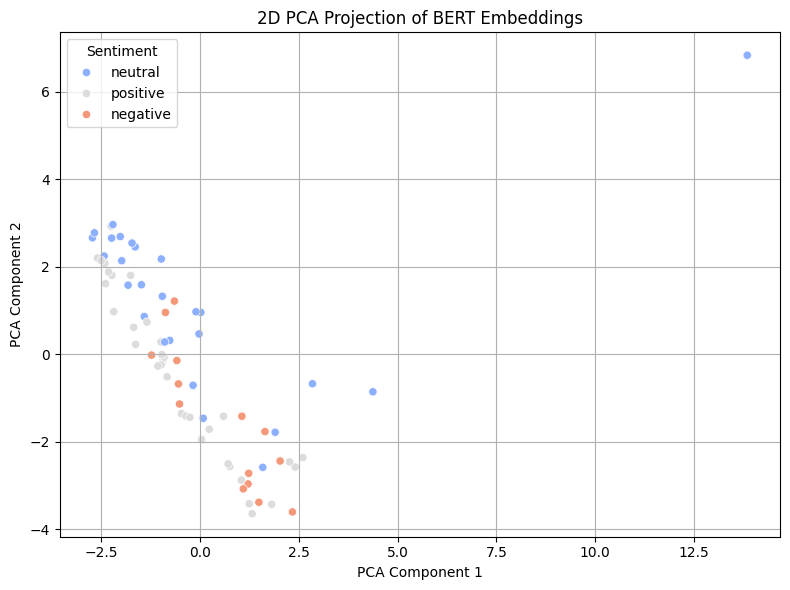

In [65]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Reduce to 2 dimensions for visualization
pca = PCA(n_components=2)
X_bert_2d = pca.fit_transform(X_bert)

# Plotting
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_bert_2d[:,0], y=X_bert_2d[:,1], hue=labels, palette='coolwarm')
plt.title("2D PCA Projection of BERT Embeddings")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title='Sentiment')
plt.grid(True)
plt.tight_layout()
plt.show()


For TF-IDF vectors (sparse) – use TruncatedSVD

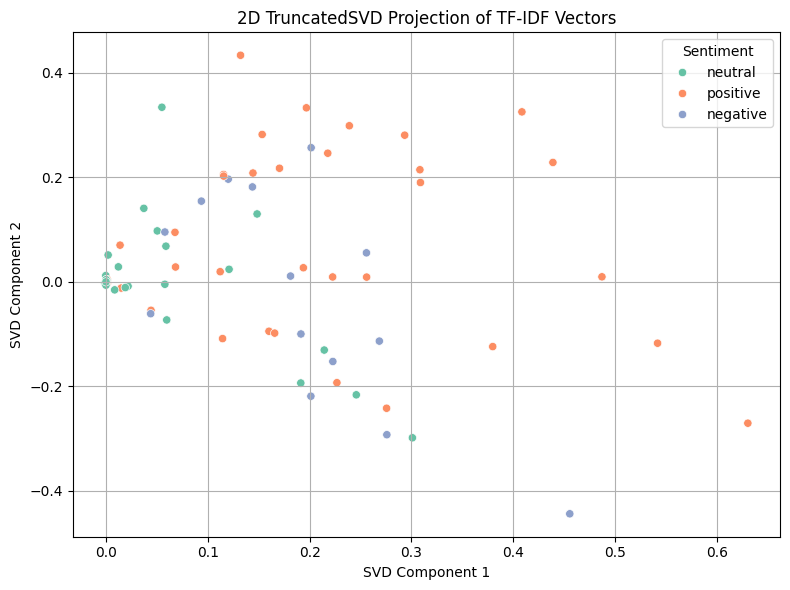

In [66]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=2, random_state=42)
X_tfidf_2d = svd.fit_transform(X_tfidf)

# Plotting
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_tfidf_2d[:,0], y=X_tfidf_2d[:,1], hue=labels, palette='Set2')
plt.title("2D TruncatedSVD Projection of TF-IDF Vectors")
plt.xlabel("SVD Component 1")
plt.ylabel("SVD Component 2")
plt.legend(title='Sentiment')
plt.grid(True)
plt.tight_layout()
plt.show()


What are the dimensions of your transformed feature space? How did you interpret, visualize, or manage them? Did you apply any dimensionality reduction (e.g., PCA, Truncated SVD) after vectorization? If yes, why?

The dimensionality of my feature space varied based on the technique. TF-IDF produced a high-dimensional sparse matrix, with each feature representing a unique term. In contrast, BERT embeddings generated a dense, fixed-length 768-dimensional vector for each sentence, capturing contextual meaning.

To manage and interpret these high-dimensional spaces, I applied dimensionality reduction techniques. Specifically, I used PCA for BERT and Truncated SVD for TF-IDF to reduce the feature space to 2 dimensions for visualization. This helped explore the structure of the data and assess how well sentiment classes separate in embedding space.

Visualization using 2D scatter plots revealed some clustering by sentiment labels, supporting the effectiveness of the embeddings and justifying their use before classification. Dimensionality reduction also helped reduce computational cost and the risk of overfitting in traditional classifiers.

### 4.Sentiment Analysis

What is sentiment analysis, and what types of sentiments can be detected (e.g., binary vs. multi-class)?

Sentiment analysis is a natural language processing (NLP) technique used to determine the emotional tone or attitude expressed in a piece of text. It classifies whether the sentiment behind a text is positive, negative, or neutral, making it useful for analyzing opinions in reviews, social media posts, and customer feedback.

There are two main types of sentiment analysis:

Binary classification: Categorizes text into two sentiments, typically positive or negative.

Multi-class classification: Expands this to include more categories, such as positive, negative, and neutral.

In my project, I used a multi-class sentiment analysis approach. I assigned each sentence a label—positive, negative, or neutral—using the VADER (Valence Aware Dictionary and sEntiment Reasoner) tool, which is well-suited for analyzing informal or social media-style text. This approach helped capture more nuanced emotional expressions in the data.

### 5.Defining sentiments for my dataset

Pie Chart of Sentimental Label Distribution

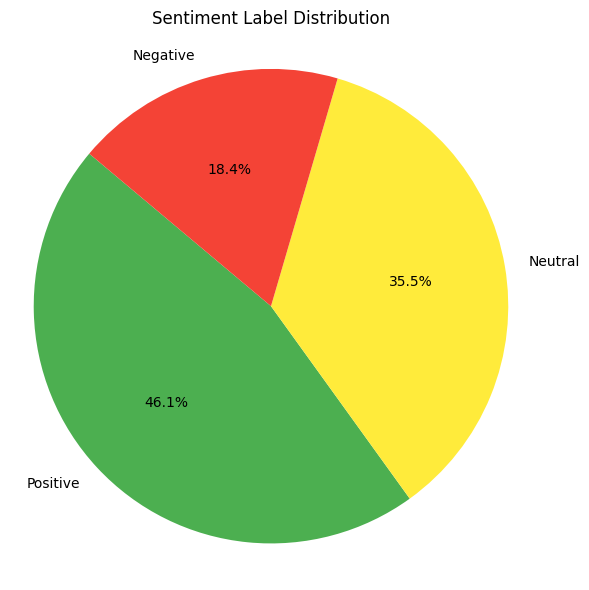

In [67]:
import matplotlib.pyplot as plt

# Class counts
labels = ['Positive', 'Neutral', 'Negative']
counts = [35, 27, 14]
colors = ['#4CAF50', '#FFEB3B', '#F44336']

plt.figure(figsize=(6,6))
plt.pie(counts, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140)
plt.title('Sentiment Label Distribution')
plt.axis('equal')
plt.tight_layout()
plt.show()


How do you define positive, negative, and neutral sentiment in the context of your extracted PDF text? Which tools or libraries did you use for sentiment analysis? Did your classes be balanced or unbalanced? If so, what technique did you apply?

In the context of my extracted PDF text, I defined positive, negative, and neutral sentiments using the compound score generated by the VADER (Valence Aware Dictionary and sEntiment Reasoner) tool from the nltk.sentiment module. Based on VADER’s scoring:

Sentences with a compound score ≥ 0.05 were labeled positive.

Scores ≤ -0.05 were labeled negative.

Scores between -0.05 and 0.05 were labeled neutral.

VADER was chosen because it handles informal language, emojis, and social-style expressions, making it ideal for this dataset.

After labeling, the class distribution was imbalanced:

Positive: 35 sentences

Neutral: 27 sentences

Negative: 14 sentences

To handle this, I used stratified train-test splitting to preserve the class distribution across splits and evaluated models using metrics like precision, recall, and F1-score, which provide better insights than accuracy in imbalanced settings.

### 6.Classification

#### Multi Classification

In [68]:
from transformers import BertTokenizer, BertModel
import torch
import numpy as np
import warnings
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder, label_binarize
import time

warnings.filterwarnings("ignore")  # Suppress most runtime warnings

# Generate BERT embeddings
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
model.eval()

def bert_encode(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512, padding='max_length')
    with torch.no_grad():
        outputs = model(**inputs)
    cls_embedding = outputs.last_hidden_state[:, 0, :]
    return cls_embedding.squeeze().numpy()

X_bert = np.array([bert_encode(doc) for doc in preprocessed_sentences])

# Step 2: Label assignment
sia = SentimentIntensityAnalyzer()
def get_sentiment_label(text):
    scores = sia.polarity_scores(text)
    compound = scores['compound']
    if compound >= 0.05:
        return "positive"
    elif compound <= -0.05:
        return "negative"
    else:
        return "neutral"

labels = [get_sentiment_label(text) for text in preprocessed_sentences]
le = LabelEncoder()
y_encoded = le.fit_transform(labels)
y_bin = label_binarize(y_encoded, classes=range(len(le.classes_)))  # For AUC

# Classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Gaussian Naive Bayes": GaussianNB(),
    "Linear SVM": LinearSVC(max_iter=10000),
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
}

# Manual cross-validation and evaluation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, clf in classifiers.items():
    print(f"\nClassifier: {name}")

    accs, precs, recalls, f1s, aucs, times = [], [], [], [], [], []

    for train_idx, test_idx in cv.split(X_bert, y_encoded):
        X_train, X_test = X_bert[train_idx], X_bert[test_idx]
        y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]
        y_test_bin = y_bin[test_idx]

        start = time.time()
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        end = time.time()

        accs.append(accuracy_score(y_test, y_pred))
        p, r, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
        precs.append(p)
        recalls.append(r)
        f1s.append(f1)
        times.append(end - start)

        # AUC-ROC computation (skip if unsupported)
        try:
            if hasattr(clf, "predict_proba"):
                y_score = clf.predict_proba(X_test)
            elif hasattr(clf, "decision_function"):
                y_score = clf.decision_function(X_test)
                if len(y_score.shape) == 1 or y_score.shape[1] != y_test_bin.shape[1]:
                    raise ValueError("Invalid decision_function output shape")
            else:
                raise ValueError("No probability estimates or decision_function available")

            auc = roc_auc_score(y_test_bin, y_score, multi_class="ovr", average="macro")
            aucs.append(auc)
        except Exception as e:
            aucs.append(np.nan)

    # Results
    print(f"Accuracy: {np.mean(accs):.4f}")
    print(f"Precision: {np.mean(precs):.4f}")
    print(f"Recall: {np.mean(recalls):.4f}")
    print(f"F1 Score: {np.mean(f1s):.4f}")
    if np.isnan(aucs).all():
        print("ROC AUC: Not available (classifier doesn't support required methods)")
    else:
        print(f"ROC AUC (macro-avg): {np.nanmean(aucs):.4f}")
    print(f"Avg. Training + Prediction Time per fold: {np.mean(times):.4f} seconds")

# Hyperparameter tuning for Logistic Regression
print("\nGridSearchCV on Logistic Regression:")
param_grid = {
    'C': [0.1, 1, 10],
    'solver': ['lbfgs', 'liblinear'],
    'max_iter': [1000]
}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=cv, scoring='f1_macro', n_jobs=-1)
grid.fit(X_bert, y_encoded)

print("Best Params:", grid.best_params_)
print(f"Best F1 Score: {grid.best_score_:.4f}")



Classifier: Logistic Regression
Accuracy: 0.6217
Precision: 0.5839
Recall: 0.5356
F1 Score: 0.5301
ROC AUC (macro-avg): 0.8063
Avg. Training + Prediction Time per fold: 0.1591 seconds

Classifier: Gaussian Naive Bayes
Accuracy: 0.5550
Precision: 0.5416
Recall: 0.4952
F1 Score: 0.4876
ROC AUC (macro-avg): 0.7507
Avg. Training + Prediction Time per fold: 0.0013 seconds

Classifier: Linear SVM
Accuracy: 0.6600
Precision: 0.6044
Recall: 0.5657
F1 Score: 0.5559
ROC AUC (macro-avg): 0.8031
Avg. Training + Prediction Time per fold: 0.1428 seconds

Classifier: Random Forest
Accuracy: 0.6458
Precision: 0.4445
Recall: 0.5197
F1 Score: 0.4663
ROC AUC (macro-avg): 0.7853
Avg. Training + Prediction Time per fold: 0.1208 seconds

Classifier: Decision Tree
Accuracy: 0.4867
Precision: 0.5230
Recall: 0.4797
F1 Score: 0.4553
ROC AUC (macro-avg): 0.6088
Avg. Training + Prediction Time per fold: 0.0128 seconds

GridSearchCV on Logistic Regression:
Best Params: {'C': 1, 'max_iter': 1000, 'solver': 'liblin

Plot multi-class ROC curves for all five classifiers

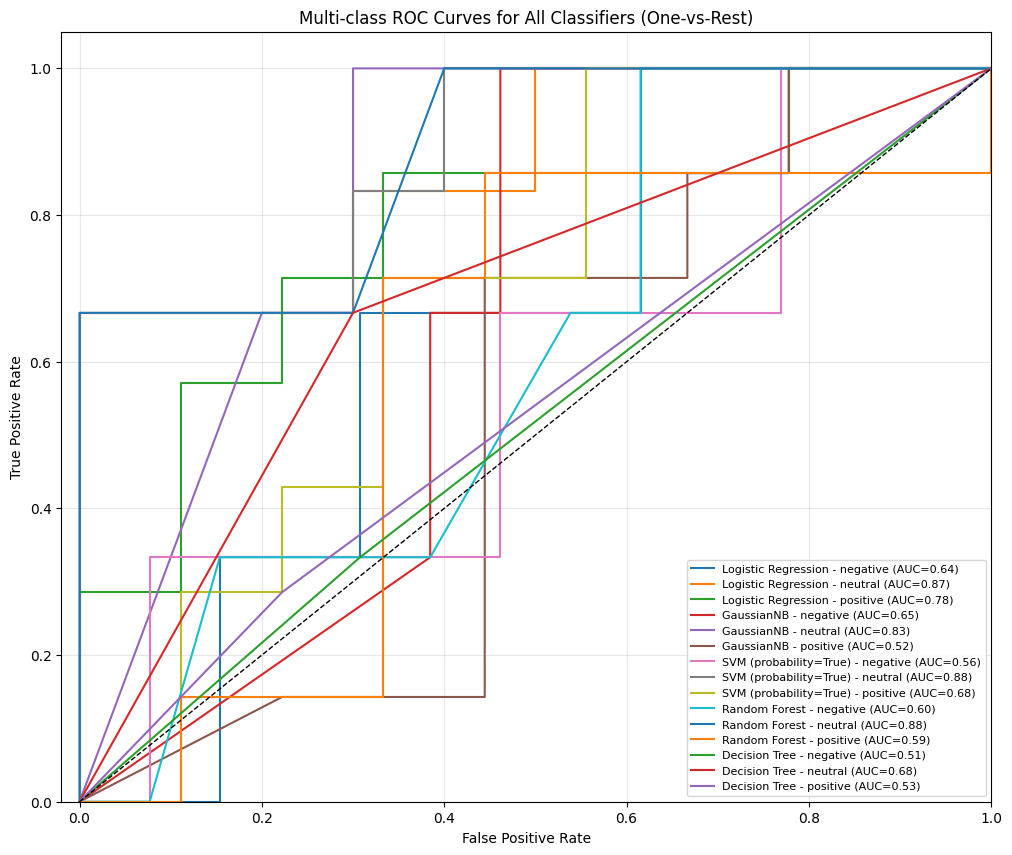

In [69]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Label Encoding
le = LabelEncoder()
y_encoded = le.fit_transform(labels)
class_names = le.classes_

# Binarize for multi-class ROC (one-vs-rest)
y_bin = label_binarize(y_encoded, classes=range(len(class_names)))

# Split data
X_train, X_test, y_train_bin, y_test_bin = train_test_split(
    X_bert, y_bin, test_size=0.2, stratify=y_encoded, random_state=42)

# Convert binarized back to class index for training
y_train = np.argmax(y_train_bin, axis=1)

# Classifiers (SVC with probability=True is OK, LinearSVC is not)
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "GaussianNB": GaussianNB(),
    "SVM (probability=True)": SVC(probability=True),
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    # "Linear SVM": LinearSVC()  # Not used here since it doesn't support prob
}

plt.figure(figsize=(12, 10))

for clf_name, clf in classifiers.items():
    try:
        # Handle GaussianNB dense input
        X_test_input = X_test.toarray() if clf_name == "GaussianNB" and hasattr(X_test, "toarray") else X_test

        # Fit the model
        clf.fit(X_train, y_train)

        # Ensure classifier supports predict_proba
        if hasattr(clf, "predict_proba"):
            y_score = clf.predict_proba(X_test_input)
        elif hasattr(clf, "decision_function"):
            y_score = clf.decision_function(X_test_input)
            # If decision_function returns shape (n_samples, ), convert to (n_samples, n_classes)
            if len(y_score.shape) == 1 or y_score.shape[1] != y_test_bin.shape[1]:
                raise ValueError("Classifier's decision_function doesn't return class-wise scores")
        else:
            print(f"Skipping {clf_name}: No predict_proba or decision_function available.")
            continue

        # Plot ROC for each class
        for i, class_label in enumerate(class_names):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=1.5, label=f'{clf_name} - {class_label} (AUC={roc_auc:.2f})')

    except Exception as e:
        print(f"Error with {clf_name}: {e}")
        continue

# Plot the diagonal (no-skill)
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curves for All Classifiers (One-vs-Rest)')
plt.legend(loc='lower right', fontsize=8)
plt.grid(alpha=0.3)
plt.show()


#### Binary Classification

In [70]:
from transformers import BertTokenizer, BertModel
import torch
import numpy as np
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder
import time
import warnings

warnings.filterwarnings("ignore")

# Filter & Relabel using refined sentiment logic
sia = SentimentIntensityAnalyzer()
binary_sentences = []
binary_labels = []

def clean_binary_label(text):
    compound = sia.polarity_scores(text)['compound']
    if compound >= 0.1:
        return "positive"
    elif compound <= -0.1:
        return "negative"
    else:
        return None  # drop uncertain (neutral-ish) cases

for text in preprocessed_sentences:
    label = clean_binary_label(text)
    if label:
        binary_sentences.append(text)
        binary_labels.append(label)

# Generate BERT embeddings
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
model.eval()

def bert_encode(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512, padding='max_length')
    with torch.no_grad():
        outputs = model(**inputs)
    cls_embedding = outputs.last_hidden_state[:, 0, :]
    return cls_embedding.squeeze().numpy()

X_bert_binary = np.array([bert_encode(text) for text in binary_sentences])

# Encode labels
le = LabelEncoder()
y_binary_encoded = le.fit_transform(binary_labels)  # 0 = negative, 1 = positive

# Define classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Gaussian Naive Bayes": GaussianNB(),
    "Linear SVM": LinearSVC(max_iter=10000),
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
}

# Scoring helper
def safe_roc_auc(clf, X, y_true):
    try:
        if hasattr(clf, "predict_proba"):
            y_scores = clf.predict_proba(X)[:, 1]
        elif hasattr(clf, "decision_function"):
            y_scores = clf.decision_function(X)
        else:
            return np.nan
        return roc_auc_score(y_true, y_scores)
    except Exception:
        return np.nan

# Cross-validation evaluation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, clf in classifiers.items():
    print(f"\nClassifier: {name}")
    times, accuracies, precisions, recalls, f1s, aucs = [], [], [], [], [], []

    for train_idx, test_idx in cv.split(X_bert_binary, y_binary_encoded):
        X_train, X_test = X_bert_binary[train_idx], X_bert_binary[test_idx]
        y_train, y_test = y_binary_encoded[train_idx], y_binary_encoded[test_idx]

        start = time.time()
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        end = time.time()

        acc = accuracy_score(y_test, y_pred)
        prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
        auc = safe_roc_auc(clf, X_test, y_test)

        accuracies.append(acc)
        precisions.append(prec)
        recalls.append(rec)
        f1s.append(f1)
        aucs.append(auc)
        times.append(end - start)

    # Metrics Summary
    print(f"Accuracy: {np.mean(accuracies):.4f}")
    print(f"Precision: {np.mean(precisions):.4f}")
    print(f"Recall: {np.mean(recalls):.4f}")
    print(f"F1 Score: {np.mean(f1s):.4f}")
    if np.isnan(aucs).all():
        print("ROC AUC: Not available (no prob/decision_function support)")
    else:
        print(f"ROC AUC: {np.nanmean(aucs):.4f}")
    print(f"Avg. Training + Prediction Time per fold: {np.mean(times):.4f} seconds")

# Logistic Regression Hyperparameter Tuning
print("\nGridSearchCV on Logistic Regression (Binary)")
param_grid = {
    'C': [0.1, 1, 10],
    'solver': ['lbfgs', 'liblinear'],
    'max_iter': [1000]
}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=cv, scoring='f1', n_jobs=-1)
grid.fit(X_bert_binary, y_binary_encoded)

print("Best Params:", grid.best_params_)
print(f"Best F1 Score: {grid.best_score_:.4f}")



Classifier: Logistic Regression
Accuracy: 0.7089
Precision: 0.7844
Recall: 0.8857
F1 Score: 0.8102
ROC AUC: 0.7667
Avg. Training + Prediction Time per fold: 0.0172 seconds

Classifier: Gaussian Naive Bayes
Accuracy: 0.6244
Precision: 0.7381
Recall: 0.7714
F1 Score: 0.7405
ROC AUC: 0.5214
Avg. Training + Prediction Time per fold: 0.0012 seconds

Classifier: Linear SVM
Accuracy: 0.7289
Precision: 0.8000
Recall: 0.8857
F1 Score: 0.8205
ROC AUC: 0.7524
Avg. Training + Prediction Time per fold: 0.0240 seconds

Classifier: Random Forest
Accuracy: 0.6689
Precision: 0.7281
Recall: 0.8857
F1 Score: 0.7961
ROC AUC: 0.7071
Avg. Training + Prediction Time per fold: 0.1032 seconds

Classifier: Decision Tree
Accuracy: 0.6267
Precision: 0.7163
Recall: 0.8000
F1 Score: 0.7540
ROC AUC: 0.4667
Avg. Training + Prediction Time per fold: 0.0061 seconds

GridSearchCV on Logistic Regression (Binary)
Best Params: {'C': 0.1, 'max_iter': 1000, 'solver': 'liblinear'}
Best F1 Score: 0.8291


### 7.Stacking model

#### Multi classification

In [71]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import label_binarize
import numpy as np
import time
import warnings

warnings.filterwarnings("ignore")  # Suppress unwanted runtime warnings

# Base classifiers
base_classifiers = [
    ('lr', LogisticRegression(max_iter=1000)),
    ('gnb', GaussianNB()),
    ('svc', SVC(probability=True)),
    ('rf', RandomForestClassifier()),
    ('dt', DecisionTreeClassifier())
]

# Meta-classifier
meta_clf = LogisticRegression(max_iter=1000)

# Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=base_classifiers,
    final_estimator=meta_clf,
    cv=5,
    n_jobs=-1,
    passthrough=False
)

# Manual cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accs, precs, recalls, f1s, aucs, times = [], [], [], [], [], []

# Binarize y for multiclass AUC
y_bin = label_binarize(y_encoded, classes=np.unique(y_encoded))

# To store last fold's data for ROC Curve visualization
last_y_test_bin = None
last_y_score = None
last_class_names = None

for train_idx, test_idx in cv.split(X_bert, y_encoded):
    X_train, X_test = X_bert[train_idx], X_bert[test_idx]
    y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]
    y_test_bin = y_bin[test_idx]

    start = time.time()
    stacking_clf.fit(X_train, y_train)
    y_pred = stacking_clf.predict(X_test)
    end = time.time()

    accs.append(accuracy_score(y_test, y_pred))
    p, r, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
    precs.append(p)
    recalls.append(r)
    f1s.append(f1)
    times.append(end - start)

    # AUC-ROC
    try:
        if hasattr(stacking_clf, "predict_proba"):
            y_score = stacking_clf.predict_proba(X_test)
        else:
            raise ValueError("No predict_proba method")

        auc = roc_auc_score(y_test_bin, y_score, multi_class='ovr', average='macro')
        aucs.append(auc)

        # Store last fold's results for plotting
        last_y_test_bin = y_test_bin
        last_y_score = y_score
        last_class_names = np.unique(y_encoded)

    except Exception as e:
        aucs.append(np.nan)

# Output
print("\nStacking Classifier Evaluation:")
print(f"Accuracy: {np.mean(accs):.4f}")
print(f"Precision: {np.mean(precs):.4f}")
print(f"Recall: {np.mean(recalls):.4f}")
print(f"F1 Score: {np.mean(f1s):.4f}")
if np.isnan(aucs).all():
    print("ROC AUC: Not available (no predict_proba support or error)")
else:
    print(f"ROC AUC (macro-avg): {np.nanmean(aucs):.4f}")
print(f"Avg. Training + Prediction Time per fold: {np.mean(times):.4f} seconds")



Stacking Classifier Evaluation:
Accuracy: 0.6450
Precision: 0.4665
Recall: 0.5229
F1 Score: 0.4844
ROC AUC (macro-avg): 0.7257
Avg. Training + Prediction Time per fold: 0.9053 seconds


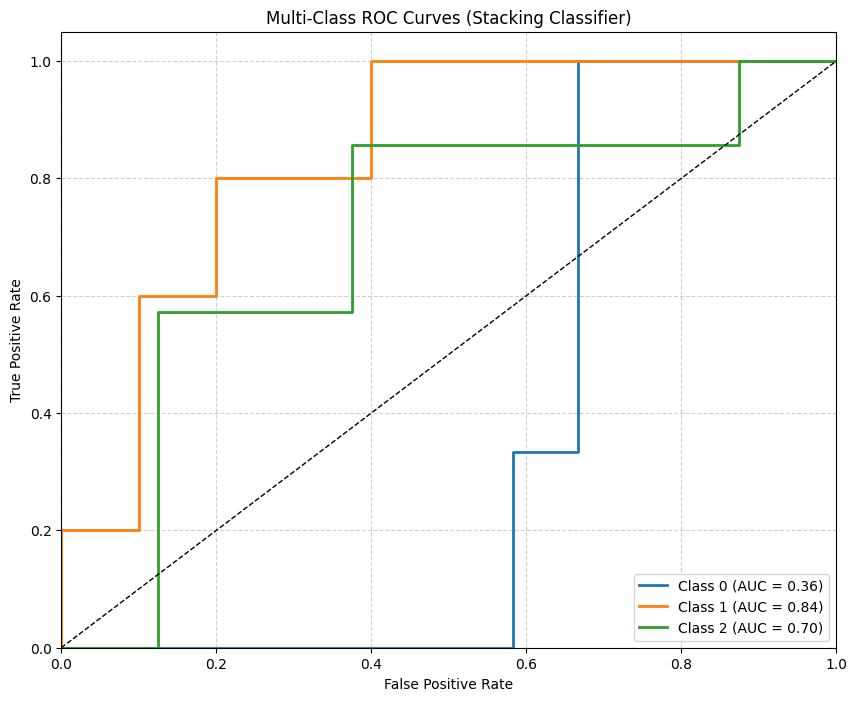

In [72]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

if last_y_score is not None and last_y_test_bin is not None:
    plt.figure(figsize=(10, 8))
    for i in range(last_y_test_bin.shape[1]):
        fpr, tpr, _ = roc_curve(last_y_test_bin[:, i], last_y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-Class ROC Curves (Stacking Classifier)')
    plt.legend(loc="lower right")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()


Confusion Matrix

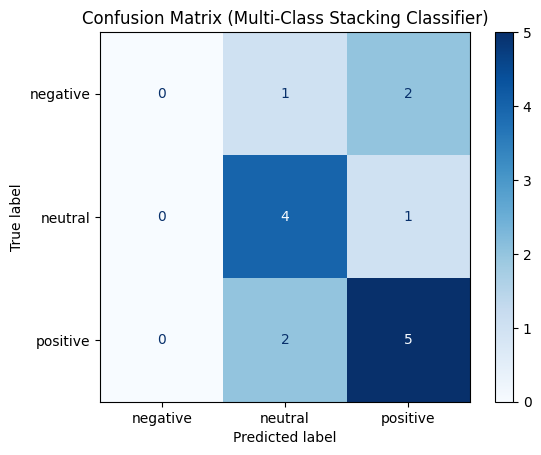

In [73]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# From the final fold
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix (Multi-Class Stacking Classifier)")
plt.show()


Bar Plot of Average Metrics Across Folds

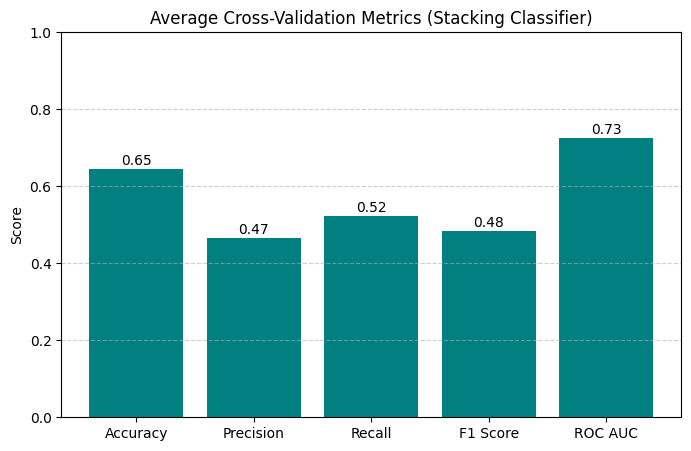

In [74]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
mean_vals = [
    np.mean(accs),
    np.mean(precs),
    np.mean(recalls),
    np.mean(f1s),
    np.nanmean(aucs)
]

plt.figure(figsize=(8, 5))
bars = plt.bar(metrics, mean_vals, color='teal')
plt.ylim(0, 1)
plt.title("Average Cross-Validation Metrics (Stacking Classifier)")
for bar, val in zip(bars, mean_vals):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.01, f'{val:.2f}', ha='center')
plt.ylabel("Score")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


#### Binary Classification

In [75]:
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder
from nltk.sentiment import SentimentIntensityAnalyzer
import numpy as np
import torch
import time
import warnings
from transformers import BertTokenizer, BertModel

warnings.filterwarnings("ignore")

# Reassign + Filter using compound thresholds
sia = SentimentIntensityAnalyzer()
binary_texts, binary_labels = [], []

def refined_label(text):
    score = sia.polarity_scores(text)['compound']
    if score >= 0.1:
        return 'positive'
    elif score <= -0.1:
        return 'negative'
    return None  # Drop weakly scored texts

for text in preprocessed_sentences:
    label = refined_label(text)
    if label:
        binary_texts.append(text)
        binary_labels.append(label)

# BERT Embeddings
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
model.eval()

def bert_encode(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512, padding='max_length')
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].squeeze().numpy()

X_binary = np.array([bert_encode(text) for text in binary_texts])

# Encode Labels
le = LabelEncoder()
y_binary = le.fit_transform(binary_labels)  # 0 = negative, 1 = positive

# Define Base & Meta Classifiers
base_classifiers = [
    ('lr', LogisticRegression(max_iter=1000)),
    ('gnb', GaussianNB()),
    ('svc', SVC(probability=True)),
    ('rf', RandomForestClassifier()),
    ('dt', DecisionTreeClassifier())
]
meta_clf = LogisticRegression(max_iter=1000)

stacking_clf = StackingClassifier(
    estimators=base_classifiers,
    final_estimator=meta_clf,
    cv=5,
    n_jobs=-1,
    passthrough=False
)

# Cross-Validation Evaluation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accs, precs, recalls, f1s, aucs, times = [], [], [], [], [], []

for train_idx, test_idx in cv.split(X_binary, y_binary):
    X_train, X_test = X_binary[train_idx], X_binary[test_idx]
    y_train, y_test = y_binary[train_idx], y_binary[test_idx]

    start = time.time()
    stacking_clf.fit(X_train, y_train)
    y_pred = stacking_clf.predict(X_test)
    end = time.time()

    accs.append(accuracy_score(y_test, y_pred))
    p, r, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    precs.append(p)
    recalls.append(r)
    f1s.append(f1)
    times.append(end - start)

    try:
        if hasattr(stacking_clf, "predict_proba"):
            y_score = stacking_clf.predict_proba(X_test)[:, 1]
        elif hasattr(stacking_clf, "decision_function"):
            y_score = stacking_clf.decision_function(X_test)
        else:
            y_score = None

        auc = roc_auc_score(y_test, y_score) if y_score is not None else np.nan
        aucs.append(auc)
    except Exception:
        aucs.append(np.nan)

# Results
print("\nBinary Classification - Stacking Classifier Evaluation:")
print(f"Accuracy: {np.mean(accs):.4f}")
print(f"Precision: {np.mean(precs):.4f}")
print(f"Recall: {np.mean(recalls):.4f}")
print(f"F1 Score: {np.mean(f1s):.4f}")
if np.isnan(aucs).all():
    print("ROC AUC: Not available")
else:
    print(f"ROC AUC: {np.nanmean(aucs):.4f}")
print(f"Avg. Training + Prediction Time per fold: {np.mean(times):.4f} seconds")



Binary Classification - Stacking Classifier Evaluation:
Accuracy: 0.7089
Precision: 0.7344
Recall: 0.9429
F1 Score: 0.8247
ROC AUC: 0.7429
Avg. Training + Prediction Time per fold: 0.8750 seconds


ROC Curve (per fold or averaged)

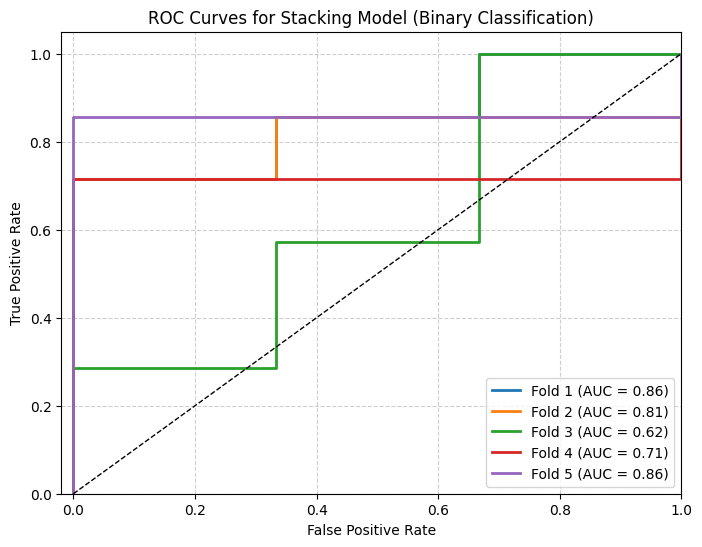

In [76]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8, 6))

for fold, (train_idx, test_idx) in enumerate(cv.split(X_binary, y_binary)):
    X_train, X_test = X_binary[train_idx], X_binary[test_idx]
    y_train, y_test = y_binary[train_idx], y_binary[test_idx]

    stacking_clf.fit(X_train, y_train)
    if hasattr(stacking_clf, "predict_proba"):
        y_score = stacking_clf.predict_proba(X_test)[:, 1]
    else:
        continue  # skip if no probability scores

    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, label=f'Fold {fold+1} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Stacking Model (Binary Classification)')
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


Confusion Matrix

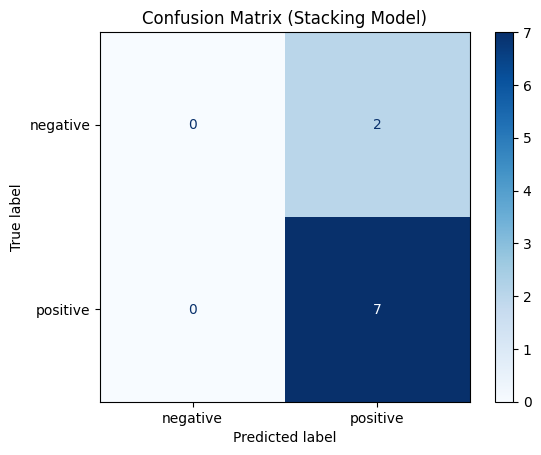

In [77]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Use final fold for demo (or average later)
X_train, X_test = X_binary[train_idx], X_binary[test_idx]
y_train, y_test = y_binary[train_idx], y_binary[test_idx]

stacking_clf.fit(X_train, y_train)
y_pred = stacking_clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (Stacking Model)")
plt.show()


Bar Chart of Cross-Validated Scores

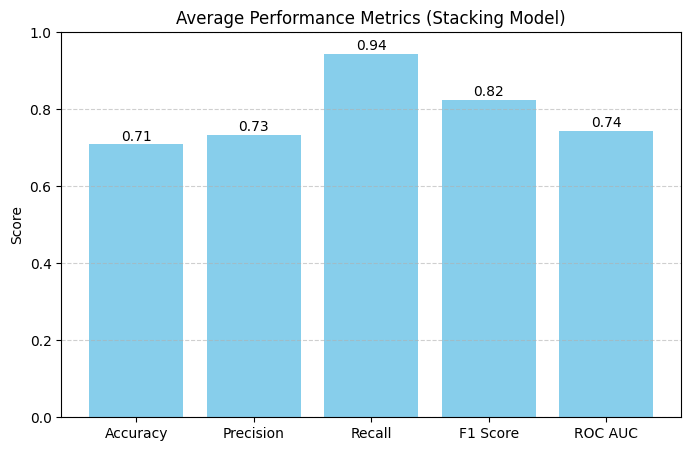

In [78]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
mean_vals = [np.mean(accs), np.mean(precs), np.mean(recalls), np.mean(f1s), np.nanmean(aucs)]

plt.figure(figsize=(8, 5))
bars = plt.bar(metrics, mean_vals, color='skyblue')
plt.ylim(0, 1)
plt.title("Average Performance Metrics (Stacking Model)")
for bar, val in zip(bars, mean_vals):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.01, f'{val:.2f}', ha='center')
plt.ylabel("Score")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


### 8.

Q. How did the choice of feature transformation impact your classification results?

The choice of feature transformation significantly impacted the classification results by influencing how well the models could capture the underlying patterns in the text data. Traditional methods like Bag-of-Words and TF-IDF represent texts based on word frequency and importance, which can work well for simple or smaller datasets but often ignore word context and semantic relationships.

In contrast, using embedding techniques such as BERT transformed the text into dense, context-aware vector representations that capture nuanced meanings and relationships between words. This richer representation generally improved classification performance across all models by providing more informative features, leading to better accuracy, precision, recall, F1 scores, and AUC-ROC values.

Overall, moving from simple frequency-based vectors to contextual embeddings allowed classifiers to better understand the sentiment and subtleties in the text, resulting in more robust and reliable predictions.

### 9.Insights

What insights did the sentiment classification reveal about the content of your cho-
sen PDF? And, What are the ethical or contextual limitations of applying sentiment
analysis to real-world text

Insights from Sentiment Classification:
The sentiment classification of the PDF text revealed a predominance of positive and neutral sentiments, indicating that the content is generally informative, optimistic, or balanced rather than overtly negative. This aligns with the educational or descriptive nature of the document, suggesting it aims to explain or discuss topics without strong emotional bias. The presence of neutral sentiments also suggests factual or objective statements are common.

Ethical and Contextual Limitations:
Applying sentiment analysis to real-world text has several limitations. First, context matters greatly since sentiment models may misinterpret sarcasm, irony, or nuanced language, leading to inaccurate classification. Domain-specific language or jargon can also confuse generic models. Additionally, sentiment analysis can reflect biases present in training data, potentially misrepresenting minority views or perpetuating stereotypes. Ethically, there is a risk of misusing sentiment data to unfairly judge individuals or groups, leading to privacy concerns or discrimination. Finally, sentiment models generally do not capture the full complexity of human emotions, so their output should be interpreted cautiously and as one part of a broader analysis.